In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

from sklearn.preprocessing import LabelEncoder

## Define functions

In [2]:
def string2date(str_date):
    try: #if the str_date has the format int-int-int
        int_date = map(lambda x:int(x),str_date.split('/'))
        return dt.date(int_date[2],int_date[0],int_date[1])
    except:
        print str_date
        return str_date

In [3]:
# import data
df_train = pd.read_csv('data/Train_pjb2QcD.csv')
df_test = pd.read_csv('data/Test_wyCirpO.csv')

### Dataset description

In [4]:
print "**size for:\n\tTrain:{0}\n\tTest{1}".format(df_train.shape,df_test.shape)


**size for:
	Train:(9527, 23)
	Test(5045, 22)


In [5]:
# preview dataset
df_train.head().T

,0,1,2,3,4
ID,FIN1000001,FIN1000002,FIN1000003,FIN1000004,FIN1000005
Office_PIN,842001,842001,800001,814112,814112
Application_Receipt_Date,4/16/2007,4/16/2007,4/16/2007,4/16/2007,4/16/2007
Applicant_City_PIN,844120,844111,844101,814112,815351
Applicant_Gender,M,M,M,M,M
Applicant_BirthDate,12/19/1971,2/17/1983,1/16/1966,2/3/1988,7/4/1985
Applicant_Marital_Status,M,S,M,S,M
Applicant_Occupation,Others,Others,Business,Salaried,Others
Applicant_Qualification,Graduate,Class XII,Class XII,Class XII,Class XII
Manager_DOJ,11/10/2005,11/10/2005,5/27/2006,8/21/2003,5/8/2006


#### - rename some columns for an easy future exploration

In [6]:
df_train.rename(columns={'Applicant_BirthDate':'Applicant_DoB','Manager_DOJ':'Manager_DoJ'}, inplace=True)

#### - Missing values and unique values
For each column we print the number of missing values as well as the number of unique values

In [7]:
miss_uniq_vals = []
for col in df_train.columns:
    miss_uniq_vals.append((100*len(df_train[df_train[col].isnull()])/float(df_train.shape[0]),len(pd.unique(df_train[col]))))
miss_uniq_vals = pd.DataFrame(miss_uniq_vals)
miss_uniq_vals.index = df_train.columns.tolist()
miss_uniq_vals.columns = ['perc_missing_val','num_uniq_val']
miss_uniq_vals

,perc_missing_val,num_uniq_val
ID,0.000000,9527
Office_PIN,0.000000,98
Application_Receipt_Date,0.000000,357
Applicant_City_PIN,1.018159,2980
Applicant_Gender,0.703264,3
Applicant_DoB,0.766243,5837
Applicant_Marital_Status,0.766243,5
Applicant_Occupation,12.816207,6
Applicant_Qualification,0.902698,12
Manager_DoJ,7.169098,647


Let's now impute missing values in each column. I will replace missing values by the most frequent value of the corresponding column

In [8]:
imputers = {}
for col in df_train.columns:
    if miss_uniq_vals.loc[col,'perc_missing_val']>0:
        # uncomment these lines to check the number of missing values before and after imputation
        #print col,'\t',df_train[df_train[col].isnull()].shape[0],'\t',
        most_freq = df_train[col].mode()[0]
        df_train[col].replace(np.nan,most_freq,inplace=True)
        imputers[col] = most_freq
        #print df_train[df_train[col].isnull()].shape[0]

#### - Data types

In [9]:
data_types = {
    'dates':['Application_Receipt_Date','Applicant_DoB','Manager_DoJ','Manager_DoB'],
    'unordered_cat':['Office_PIN','Applicant_City_PIN','Applicant_Gender','Applicant_Marital_Status',
                   'Applicant_Occupation','Applicant_Qualification','Manager_Status','Manager_Gender',
                   'Manager_Business','Manager_Business2','Business_Sourced'],
    'ordered_cat':['Manager_Joining_Designation','Manager_Current_Designation'],
    'integers':['Manager_Grade','Manager_Num_Application','Manager_Num_Coded','Manager_Num_Products',
                'Manager_Num_Products2']
}

Now, we convert each column to its proper data type and prepare a label encoder to transform categorical into numeric. this will be used later

In [10]:
label_encoders = {}
for col in df_train.columns[:-1]: # dont convert target column yet
    if col in data_types['dates']:
        df_train[col] = df_train[col].apply(lambda x:string2date(x))
    if col in data_types['ordered_cat']:
        df_train[col] = pd.Categorical(df_train[col],ordered=True)
        label_encoders[col] = LabelEncoder()
        label_encoders[col].fit(df_train[col])
    if col in data_types['unordered_cat']:
        df_train[col] = pd.Categorical(df_train[col],ordered=False)
        label_encoders[col] = LabelEncoder()
        label_encoders[col].fit(df_train[col])
    if col in data_types['integers']:
        df_train[col] = df_train[col].astype(int)

### Univariate Data Exploration and Engineering

#### - Target label

In [11]:
print "The probability of picking a positive Business Sourced is",df_train[df_train.Business_Sourced == 1].shape[0]/float(df_train.shape[0])

The probability of picking a positive Business Sourced is 0.342920121759


#### - Date type

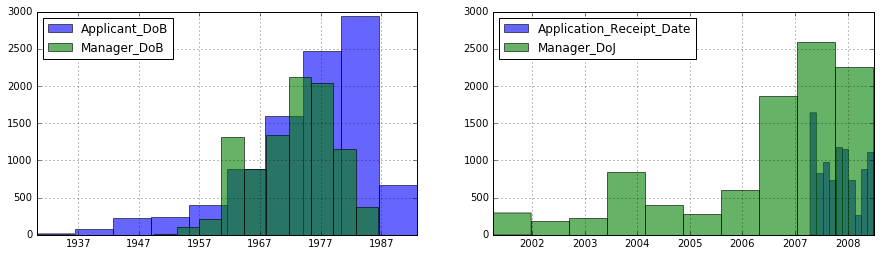

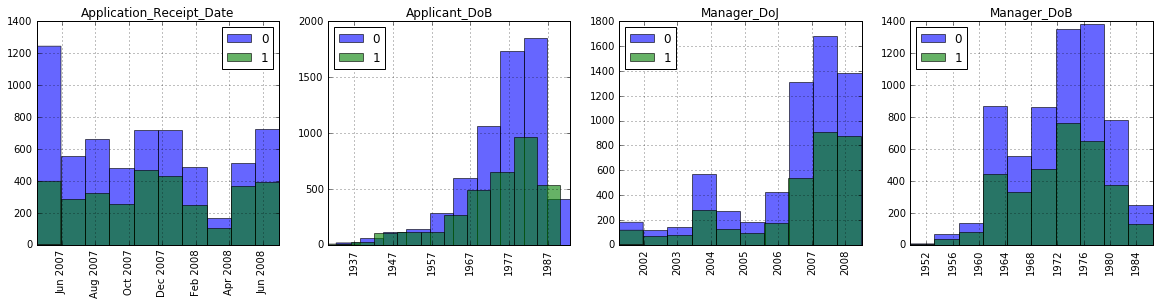

In [12]:
# We plot earlier (date of births) and later dates separately
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
legends1 = []
legends2 = []
for col in data_types['dates']:
    if 'DoB' in col:
        df_train[col].hist(alpha=0.6,ax=ax1)
        legends1.append(col)
    else:
        df_train[col].hist(alpha=0.6,ax=ax2)
        legends2.append(col)
ax1.legend(legends1,loc='best')
ax2.legend(legends2,loc='best')
plt.show()

# plot, the target label as function of each date column
fig, ax = plt.subplots(1,4,figsize=(20,4))
for col in data_types['dates']:
    df_train[col][df_train.Business_Sourced == 0].hist(alpha = 0.6,ax=ax[data_types['dates'].index(col)],xrot=90)
    df_train[col][df_train.Business_Sourced == 1].hist(alpha = 0.6,ax=ax[data_types['dates'].index(col)],xrot=90)
    #ax[data_types['dates'].index(col)].plot(df_train[col],df_train.Business_Sourced,'bo',alpha = 0.5)
    ax[data_types['dates'].index(col)].set_title(col)
    ax[data_types['dates'].index(col)].legend([0,1],loc='best')
plt.show()



- Approximately applicants are about 10 years younger managers (top-left figure)
- There was a hug increase in hiring managers starting with mid 2006, followed by hiring new applicants as well in 2007. However it looks like the number of applicants started to decrease in beginning 2008

It would also be interesting to look at:
- Difference in age between manager and applicant
- Look at Business Sourced as function of just years or months (but not dates)
- Manager's experience time with the firm. This is the time between Applicant's receipt date and when the manager joined. **Note**: Some value may turn to be negative. This would mean that the manager joined after an application has been filed

So, let's create new data columns first

In [71]:
df_train['Applicant_Manager_DA'] = np.array(map(lambda x:float(x.days),df_train.Applicant_DoB - df_train.Manager_DoB))/365
df_train['Applicant_DoB_Year'] = df_train.Applicant_DoB.apply(lambda x:x.year)
df_train['Manager_DoB_Year'] = df_train.Manager_DoB.apply(lambda x:x.year)
df_train['Applicant_RD_Month'] = df_train.Application_Receipt_Date.apply(lambda x:x.month)
df_train['Manager_DoJ_Year'] = df_train.Manager_DoJ.apply(lambda x:x.year)
df_train['Manager_Experience'] = np.array(map(lambda x:x.days,df_train.Application_Receipt_Date - df_train.Manager_DoJ))/365
new_cols = ['Applicant_Manager_DA','Applicant_DoB_Year','Manager_DoB_Year','Applicant_RD_Month','Manager_DoJ_Year','Manager_Experience']

In [72]:
df_train[new_cols].describe()

,Applicant_Manager_DA,Applicant_DoB_Year,Manager_DoB_Year,Applicant_RD_Month,Manager_DoJ_Year,Manager_Experience
count,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000,9527.000000
mean,2.938533,1974.817046,1971.904062,6.714601,2005.894825,1.009552
std,11.553439,10.257713,6.812725,3.129828,1.777298,1.618642
min,-47.090411,1930.000000,1949.000000,1.000000,2001.000000,-1.000000
25%,-2.854795,1970.000000,1967.000000,5.000000,2005.000000,0.000000
50%,3.545205,1978.000000,1973.000000,6.000000,2007.000000,0.000000
75%,10.234247,1982.000000,1977.000000,9.000000,2007.000000,1.000000
max,35.430137,1992.000000,1986.000000,12.000000,2008.000000,7.000000


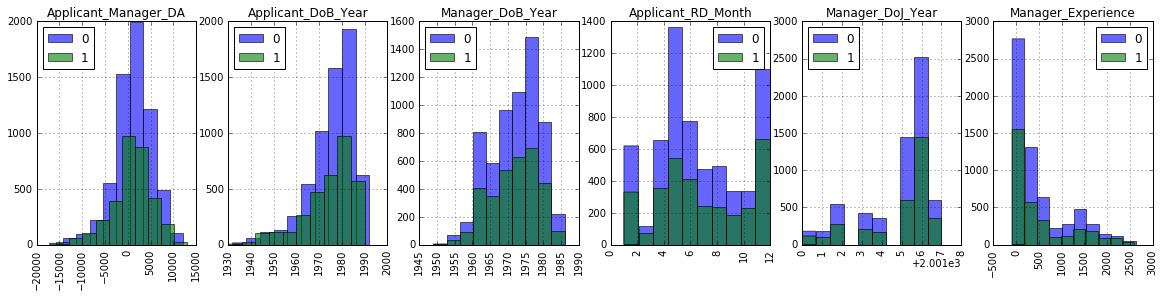

In [14]:
fig, ax = plt.subplots(1,6,figsize=(20,4))
for col in new_cols:
    df_train[col][df_train.Business_Sourced == 0].hist(alpha = 0.6,ax=ax[new_cols.index(col)],xrot=90)
    df_train[col][df_train.Business_Sourced == 1].hist(alpha = 0.6,ax=ax[new_cols.index(col)],xrot=90)
    #ax[data_types['dates'].index(col)].plot(df_train[col],df_train.Business_Sourced,'bo',alpha = 0.5)
    ax[new_cols.index(col)].set_title(col)
    ax[new_cols.index(col)].legend([0,1],loc='best')
plt.show()

#### - Ordered categorical data

Of interest here would also be to see how a manager has progressed in levels since he joined until the application receipt date. To make it fancy this can be  normalized over the time he has been with the firm.

In [65]:
c1 = 'Manager_Current_Designation'
c2 = 'Manager_Joining_Designation'
df_train['Manager_Promotion'] = label_encoders[c1].transform(df_train[c1]) - label_encoders[c2].transform(df_train[c2])
# calculate the promotion (yearly) rate. Here, I assume 365 days in a year
df_train['Manager_Promotion_Rate'] = df_train['Manager_Promotion']/(df_train['Manager_Experience']/365)
print df_train[['Manager_Promotion','Manager_Promotion_Rate']].describe()

       Manager_Promotion  Manager_Promotion_Rate
count        9527.000000             9527.000000
mean            0.549071                     inf
std             0.995624                     NaN
min            -7.000000             -121.666667
25%             0.000000                0.000000
50%             0.000000                0.000000
75%             1.000000                0.425284
max             4.000000                     inf


In [66]:
#df_train['Manager_Promotion_Rate'].hist()

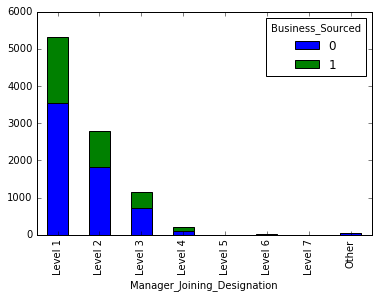

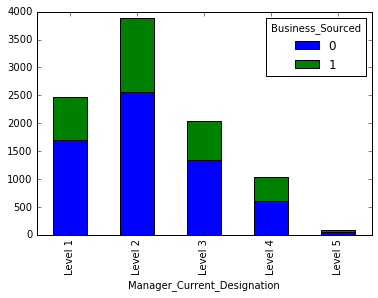

In [43]:
#print data_types['ordered_cat']
#fig,ax = plt.subplots(1,2,figsize = (14,4))
for col in data_types['ordered_cat']:
    #generate cross table first
    ct = pd.crosstab(df_train[col],df_train['Business_Sourced'],margins=True)
    #ct = ct/ct.iloc[-1] #normalize
    ct.iloc[:-1,:-1].plot(kind='bar',stacked=True)

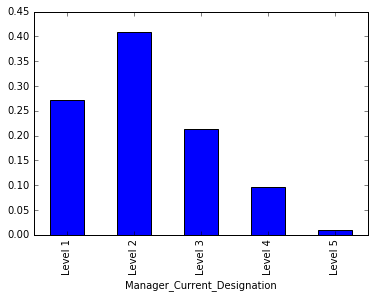

In [33]:
ct.iloc[:-1,0].plot(kind='bar')

#### - Unordered categorical data

#### - Integer data

In [ ]:
data_types['integers']

In [ ]:
fig,ax = plt.subplots(1,5,figsize=[20,4])
for col in data_types['integers']:
    df_train[col][df_train.Business_Sourced == 0].hist(alpha=0.5,ax=ax[data_types['integers'].index(col)])
    df_train[col][df_train.Business_Sourced == 1].hist(alpha=0.5,ax=ax[data_types['integers'].index(col)])
    ax[data_types['integers'].index(col)].set_title(col)
    ax[data_types['integers'].index(col)].legend([0,1], loc='best')
plt.show()